In [9]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# check your gpu is available:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# for tensorflow instance:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
import time
import random
import os
from glob import glob
from skimage import io
from statistics import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
from keras.utils import to_categorical
from statistics import mode
from mlxtend.plotting import plot_confusion_matrix
from skimage.transform import resize, pyramid_reduce
import keras
from keras import backend as K
import tensorflow as tf

In [0]:
gdrive_path = '/content/drive/My Drive/Colab Notebooks/'
load_dir = gdrive_path + 'DLBCL'
img_format = 'tif'
Base_foldername = 'TestRun1'
Model_name = 'VGGNet19v2'
Model_file = 'model.h5'
version = 2

base_dir = os.path.join(load_dir, Base_foldername)
model_dir = os.path.join(os.path.join(base_dir, Model_name), Model_file)
test_dir = os.path.join(os.path.join(base_dir, 'Test'), '*.' + img_format)
save_dir = os.path.join(base_dir, Model_name)

In [0]:
def TEST(DataPath, ModelPath, LoadPath, SavePath, Model_name, Base_foldername, PatchSize, version, Sort_ID, true_label_exist, overlap, overlap_PatchCount,DownscaleTiled,DownscaleTimes):
  model = load_Model(ModelPath,SavePath)
  FnameList = load_Data(DataPath, version)
  df = build_df(FnameList, true_label_exist)
  y_pred_labels = []
  y_true_labels = []
  x_data = []
  for Index in range(len(df)):
    if overlap:
      image, PatchList = gen_overlap_Plist(df, FnameList, Index, PatchSize, overlap_PatchCount,DownscaleTiled,DownscaleTimes)
    else:
      image, PatchList = gen_non_overlap_Plist(df, FnameList, Index, PatchSize,DownscaleTiled,DownscaleTimes)
    X, Y, PatchCount = build_testset(df, true_label_exist, Index, PatchList)
    pred, pred_label = predict_testset(df, model, Index, X, PatchCount)
    
    print(df.iloc[Index, : ])
#     plt.imshow(image)
#     plt.title(pred_label,fontsize=30)
#     plt.show()
    show_ingroup(image,pred_label)
#     print('\n')     
#     pred_class = model.predict_classes(X)
#     print(pred_class)
#     print('\n')
#     df_pred = pd.DataFrame(pred, columns=['benign(0|-)', 'malignant(1|+)'])
#     print('df_pred shape:', df_pred.shape)
#     print('\n')
#     print(df_pred.to_string(formatters={'benign(0|-)': '{:,.2}'.format,
#                                         'malignant(1|+)': '{:,.2}'.format}))
    print('\n\n\n')
    if Index == 0:
      y_pred_labels = pred
      y_true_labels = Y
      x_data = X
    else:
      y_pred_labels = np.concatenate((y_pred_labels, pred))
      y_true_labels = np.concatenate((y_true_labels, Y))
      x_data = np.concatenate((x_data, X))
  
  print_details(df, SavePath, Sort_ID, true_label_exist)
  cm  = confusion_matrix(df, SavePath)
  test_inference(cm, LoadPath, Model_name, Base_foldername)
  return len(df)
    

def load_Model(ModelPath,SavePath):
  model = load_model(ModelPath)
#   saver = tf.train.Saver()
#   sess = keras.backend.get_session()
#   path = SavePath + "/session.ckpt"
#   saver.restore(sess,path)
  return model


def load_Data(DataPath, version):
  FnameList = glob(DataPath, recursive=True)
  df = pd.DataFrame(FnameList, columns=['File'])
  df['ID'] = df['File'].apply(extract_id)
  df['ID'] = df['ID'].astype('int64')
  df = df.sort_values(by=['ID','File'])
  byID = df.groupby(by="ID")
  FnameList=[]
  for ID, group in byID:
    k=[]
    if version == 1:
      for i in [x for x in range(len(group)) if x == 0]:
        k.append((group.iloc[:,[0]]).iloc[i,0])
      FnameList.append(k)

    if version == 2:
      for i in [x for x in range(len(group))]:
        k.append((group.iloc[:,[0]]).iloc[i,0])
      FnameList.append(k)

    if version == 3:
      for i in [x for x in range(len(group)) if x != 2]:
        k.append((group.iloc[:,[0]]).iloc[i,0])
      FnameList.append(k)
  print('Loaded file count:', np.array(FnameList).shape)
  return FnameList


def extract_id(s):                          
    try:
      x = s
      x = x.rsplit("\\", maxsplit=1)
      x = x[1]
    except:
      x = s
      x = x.rsplit('/', maxsplit=1)
      x = x[1]
    finally:
      x = x.split("_", maxsplit=2)
      if len(x)==2:
        ID = x[0]
      elif len(x)==3:
        ID = x[1]
    return ID

  
def extract_class(x):
    try:
      x = x.rsplit("_", maxsplit=1)
      x = x[1]
      x = x.split(".")
      x = x[0]
      if x == 'neg' or x == 'Neg':
        Class = 0
      elif x == 'pos' or x == 'Pos':
        Class = 1
    except:
      Class = 'None'

    return Class

  
def build_df(FnameList, true_label_exist):
  FList=[]
  for i in range(len(FnameList)):
    FList.append(FnameList[i][0])
  df = pd.DataFrame(FList, columns=['Test File'])

  # create a new column called 'ID'
  df['ID'] = df['Test File'].apply(extract_id)
  
  if true_label_exist:
    # create a new column called 'class'
    df['True Label'] = df['Test File'].apply(extract_class)

  print('df shape:', df.shape)
  print('\n\n')
  
#   print(len(df),len(FnameList))
#   print(df.to_string())
#   for Fname in FnameList:
#     print(Fname)

  return df
  
  
def gen_non_overlap_Plist(df, FnameList, Index, PatchSize,DownscaleTiled,DownscaleTimes):
  for j in range(np.array(FnameList).shape[1]):
    z = np.array(io.imread(FnameList[Index][j]))
    if len(z.shape)==2:
      z = to_RGB(z)
    if j>0:
      image=np.concatenate((image, z), axis=-1)
    else:
      image = z
  print(image.shape)

  if DownscaleTiled:
    image = to_DownscaledTiles(image,DownscaleTimes)  
    print(image.shape)

  __builtins__.W = PatchSize
  __builtins__.H = PatchSize
  __builtins__.C = image.shape[-1]
  PatchList = [image[x:x+W,y:y+H] for x in range(0,image.shape[0],W) for y in range(0,image.shape[1],H)]

  return image, PatchList

  
def gen_overlap_Plist(df, FnameList, Index, PatchSize, overlap_PatchCount,DownscaleTiled,DownscaleTimes):
  for j in range(np.array(FnameList).shape[1]):
    z = np.array(io.imread(FnameList[Index][j]))
    if len(z.shape)==2:
      z = to_RGB(z)
    if j>0:
      image=np.concatenate((image, z), axis=-1)
    else:
      image = z
  #print(image.shape)

  if DownscaleTiled:
    image = to_DownscaledTiles(image,DownscaleTimes)  
    #print(image.shape)
  __builtins__.W = PatchSize
  __builtins__.H = PatchSize
  __builtins__.C = image.shape[-1]

  PatchList=[]
  idxs = []
  for i in range(0, overlap_PatchCount):
        start_row_idx = random.randint(0, image.shape[1]-H-1)
        start_col_idx = random.randint(0, image.shape[0]-W-1)
        if (start_row_idx,start_col_idx) not in idxs:
          p = image[start_row_idx:(start_row_idx+H), start_col_idx:(start_col_idx+W), :]
          PatchList.append(p)
          idxs.append((start_row_idx, start_col_idx))
          
  return image, PatchList

    
def build_testset(df, true_label_exist, Index, PatchList):
  X=[]
  Y=[]
  ScrapCount=0
  for Patch in PatchList:
    if (np.array(Patch)).shape != (W,H,C):
      ScrapCount+=1
      continue
    X.append(Patch)
    if true_label_exist:
      if int(df.iloc[Index, 2]) == 0:
        Y.append(0)
      elif int(df.iloc[Index, 2]) == 1:
        Y.append(1)
  
  PatchCount = len(PatchList)-ScrapCount    
  print('Total patch count from image ID',df.iloc[Index,1],':',len(PatchList),'-',ScrapCount,'=',PatchCount)
  X=np.array(X)
  X = X.astype(np.float32)
  X /= 255
  if true_label_exist:
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes = 2)
  
  return X, Y, PatchCount
  
  
def predict_testset(df, model, Index, X, PatchCount):
  prediction = model.predict(X, verbose=1)
  
  pred_Llist=[]
  for i in range(PatchCount):
    if prediction[i][0] > 0.5 :#and prediction[i][1] < 0.5:
      pred_Llist.append(0)
    elif prediction[i][0] <= 0.5 :#and prediction[i][1] > 0.5:
      pred_Llist.append(1)

      
  if mode(pred_Llist) == 0:
    df.loc[Index, 'Predicted Label'] = '0'
    pred_label = 'Benign(0)'
  elif mode(pred_Llist) == 1:
    df.loc[Index, 'Predicted Label'] = '1'
    pred_label = 'Malignant(1)'

  
  return prediction, pred_label
  
  
def print_details(df, SavePath, Sort_ID, true_label_exist):
  if Sort_ID:
    df = df.astype({"ID": int})
    df = df.sort_values(by ='ID')
  print(df.to_string())
  df.to_csv(SavePath + '/test_df.csv')

  if true_label_exist:
    misclass_label = class_label = 0
    misclass_id=[]
    for i in range(len(df)):
      if df.iloc[i, 2] == 'None':
        continue
      elif int(df.iloc[i, 2]) != int(df.iloc[i, 3]):
        misclass_label +=1
        misclass_id.append(df.iloc[i, 1])
      elif int(df.iloc[i, 2]) == int(df.iloc[i, 3]):
        class_label +=1
    print('\n\n')
    print('Classified Predicted Label Count     :', class_label, '/', len(df))
    print('Misclassified Predicted Label Count  :', misclass_label, '/', len(df))
    print('Misclassified ID:',misclass_id)

      
def confusion_matrix(df, SavePath):
  cm=np.zeros([2, 2], dtype = int)
  for i in range(len(df)):
    if int(df.iloc[i,2])==0 and int(df.iloc[i,3])==0:
      cm[0,0]+=1
    elif int(df.iloc[i,2])==0 and int(df.iloc[i,3])==1:
      cm[0,1]+=1
    elif int(df.iloc[i,2])==1 and int(df.iloc[i,3])==0:
      cm[1,0]+=1
    elif int(df.iloc[i,2])==1 and int(df.iloc[i,3])==1:
      cm[1,1]+=1

  cm_plot_labels = ['neg(0)', 'pos(1)']
  fig, ax = plot_confusion_matrix(conf_mat=cm, 
                              #class_names=cm_plot_labels,
                              colorbar=True,
                              show_absolute=True,
                              show_normed=False,
                              figsize=(5,5),
                              cmap='Greens')
  plt.savefig(SavePath + '/test_cm.png',dpi=1200)
  plt.show()
  print('\n\n')
  return cm

def test_inference(cm, LoadPath, Model_name, Base_foldername):
  csvFilePath = LoadPath + '/test_inference.csv'
  
  TN = int(cm[0,0])
  FP = int(cm[0,1])
  FN = int(cm[1,0])
  TP = int(cm[1,1])
  total = TN + FP + FN + TP 
  
  df_cm = pd.DataFrame(columns=['Base-Name', 'Model-Name', 'TP', 'TN', 'FP', 'FN', 'Accuracy', 'Inaccuracy', 'Sensitivity', 'Specificity', 'Precision', 'F-Score'])
  #df_cm = df_cm.rename_axis('Index', axis=1)
  df_cm.loc[0, 'Base-Name'] = Base_foldername
  df_cm.loc[0, 'Model-Name'] = Model_name
  df_cm.loc[0, 'TP'] = TP
  df_cm.loc[0, 'TN'] = TN
  df_cm.loc[0, 'FP'] = FP
  df_cm.loc[0, 'FN'] = FN
  try:
    df_cm.loc[0, 'Accuracy'] = (TP + TN) / total 
  except ZeroDivisionError:
    df_cm.loc[0, 'Accuracy'] = 0
  try:
    df_cm.loc[0, 'Inaccuracy'] = (FP + FN) / total
  except ZeroDivisionError:
    df_cm.loc[0, 'Inaccuracy'] = 0
  try:
    df_cm.loc[0, 'Sensitivity'] = TP / (TP + FN)
  except ZeroDivisionError:
    df_cm.loc[0, 'Sensitivity'] = 0
  try:
    df_cm.loc[0, 'Specificity'] = TN / (TN + FP)
  except ZeroDivisionError:
    df_cm.loc[0, 'Specificity'] = 0  
  try:
    df_cm.loc[0, 'Precision'] = TP / (TP + FP)
  except ZeroDivisionError:
    df_cm.loc[0, 'Precision'] = 0  
  try:
    df_cm.loc[0, 'F-Score'] = (2*(TP / (TP + FN))*(TP / (TP + FP))) / ((TP / (TP + FN))+(TP / (TP + FP)))
  except ZeroDivisionError:
    df_cm.loc[0, 'F-Score'] = 0  
  
  df_cm['Base-Name'] = df_cm['Base-Name'].astype('str')
  df_cm['Model-Name'] = df_cm['Model-Name'].astype('str')
  df_cm['TP'] = df_cm['TP'].astype('int64')
  df_cm['TN'] = df_cm['TN'].astype('int64')
  df_cm['FP'] = df_cm['FP'].astype('int64')
  df_cm['FN'] = df_cm['FN'].astype('int64')
  df_cm['Accuracy'] = df_cm['Accuracy'].astype('float64')
  df_cm['Inaccuracy'] = df_cm['Inaccuracy'].astype('float64')
  df_cm['Sensitivity'] = df_cm['Sensitivity'].astype('float64')
  df_cm['Specificity'] = df_cm['Specificity'].astype('float64')
  df_cm['Precision'] = df_cm['Precision'].astype('float64')
  df_cm['F-Score'] = df_cm['F-Score'].astype('float64')

  if os.path.isfile(csvFilePath):
    df_cm_import = pd.read_csv(csvFilePath, index_col=[0])
    df_cm_import = df_cm_import.drop_duplicates().reset_index(drop=True)
    df_cm_export = pd.concat([df_cm_import, df_cm], ignore_index=True, sort=False)
    df_cm_export = df_cm_export.drop_duplicates().reset_index(drop=True)
    df_cm_export.to_csv(csvFilePath)
    print(df_cm_export.to_string())
    #print(df_cm_export.dtypes)
  else:
    df_cm.to_csv(csvFilePath)
    print(df_cm.to_string())
    
def show_ingroup(im,pred_label):
  c=0
  if im.shape[-1]<12:
    for _ in range(im.shape[-1]//3):
      x = im[:, :, c:c+3]
      plt.imshow(x)
      plt.title(pred_label, fontsize=15)
      c+=3
      plt.show()
  else:
    for _ in range(im.shape[-1]//12):
      fig = plt.figure(figsize=(20, 20))
      ax1 = fig.add_subplot(1,4,1)
      x=im[:, :, c:c+3]
      ax1.imshow(x)
      ax1.set_title(pred_label,fontsize=15)
      c+=3
      ax2 = fig.add_subplot(1,4,2)
      x=im[:, :, c:c+3]
      ax2.imshow(x)
      ax2.set_title(pred_label,fontsize=15)
      c+=3
      ax3 = fig.add_subplot(1,4,3)
      x=im[:, :, c:c+3]
      ax3.imshow(x)
      ax3.set_title(pred_label,fontsize=15)
      c+=3
      ax4 = fig.add_subplot(1,4,4)
      x=im[:, :, c:c+3]
      ax4.imshow(x)
      ax4.set_title(pred_label,fontsize=15)
      c+=3
    plt.show()
    
def to_DownscaledTiles(image,DownscaleTimes):
  k=[]
  c=0
  for i in range(image.shape[-1]//3):
    x=pyramid_reduce(image[:,:,c:c+3], downscale=2, sigma=None, order=1, mode='reflect', cval=0, multichannel=True)
    x *= 255 
    x = x.astype(np.uint8)
    x=np.concatenate((x,x), axis=0)
    x=np.concatenate((x,x), axis=1)
    k.append(x)
    c+=3
  if DownscaleTimes==2:
    c=0  
    for i in range(image.shape[-1]//3):
      x=pyramid_reduce(image[:,:,c:c+3], downscale=4, sigma=None, order=1, mode='reflect', cval=0, multichannel=True)
      x *= 255 
      x = x.astype(np.uint8)
      x=np.concatenate((x,x,x,x), axis=0)
      x=np.concatenate((x,x,x,x), axis=1)
      k.append(x)
      c+=3
  for i in k:
    image=np.concatenate((image, i), axis=-1)
  return image
  
def to_RGB(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    #ret[:, :, 0] = im
    #ret[:, :, 1] = im
    #ret[:, :, 2] = im
    ret[:, :, :] = im[:, :, np.newaxis]
    return ret

In [0]:
start_t = time.time()
count= TEST(test_dir, 
       model_dir, 
       load_dir, 
       save_dir, 
       Model_name, 
       Base_foldername, 
       PatchSize=100,
       version=version,
       Sort_ID=True, 
       true_label_exist=True, 
       overlap=False, 
       overlap_PatchCount=None,
       DownscaleTiled=False,
       DownscaleTimes=2)
end_t = time.time()
print(f"Test time per image: {(end_t - start_t)/count}")

In [6]:
csvFilePath = load_dir + '/test_inference.csv'
df = pd.read_csv(csvFilePath, index_col=[0])
#df

df_copy = df.copy(deep=True)
df_copy['Accuracy'] = df_copy['Accuracy'].map("{:.1%}".format)
df_copy['Inaccuracy'] = df_copy['Inaccuracy'].map("{:.1%}".format)
df_copy['Sensitivity'] = df_copy['Sensitivity'].map("{:.1%}".format)
df_copy['Specificity'] = df_copy['Specificity'].map("{:.1%}".format)
df_copy['Precision'] = df_copy['Precision'].map("{:.1%}".format)
df_copy['F-Score'] = df_copy['F-Score'].map("{:.1%}".format)
print(df_copy.to_string(),file=open(load_dir + "/output.txt", "w"))
df_copy

,Base-Name,Model-Name,TP,TN,FP,FN,Accuracy,Inaccuracy,Sensitivity,Specificity,Precision,F-Score
0,TestRun1,VGGNet19,6,14,1,2,87.0%,13.0%,75.0%,93.3%,85.7%,80.0%
1,TestRun1,VGGNet19v2,6,12,3,2,78.3%,21.7%,75.0%,80.0%,66.7%,70.6%
2,TestRun1,VGGNet19v4,6,13,2,2,82.6%,17.4%,75.0%,86.7%,75.0%,75.0%
3,TestRun2,VGGNet19,4,15,3,1,82.6%,17.4%,80.0%,83.3%,57.1%,66.7%
4,TestRun2,VGGNet19v2,3,16,2,2,82.6%,17.4%,60.0%,88.9%,60.0%,60.0%
5,TestRun2,VGGNet19v4,3,16,2,2,82.6%,17.4%,60.0%,88.9%,60.0%,60.0%
6,TestRun3,VGGNet19,9,9,4,1,78.3%,21.7%,90.0%,69.2%,69.2%,78.3%
7,TestRun3,VGGNet19v2,5,8,5,5,56.5%,43.5%,50.0%,61.5%,50.0%,50.0%
8,TestRun3,VGGNet19v4,9,8,5,1,73.9%,26.1%,90.0%,61.5%,64.3%,75.0%
9,TestRun4,VGGNet19,8,12,1,2,87.0%,13.0%,80.0%,92.3%,88.9%,84.2%


In [7]:
byModel = df.groupby(by="Model-Name")
print(byModel.describe().to_string(),file=open(load_dir + "/output.txt", "a"))
byModel.describe()

TP                      ...   F-Score                              
           count mean       std  min  ...       25%       50%       75%       max
Model-Name                            ...                                        
VGGNet19    10.0  7.2  1.619328  4.0  ...  0.805882  0.832817  0.917308  0.947368
VGGNet19v2  10.0  6.2  1.813529  3.0  ...  0.626471  0.797980  0.853383  0.933333
VGGNet19v4  10.0  7.2  1.932184  3.0  ...  0.768382  0.861765  0.917308  1.000000

[3 rows x 80 columns]

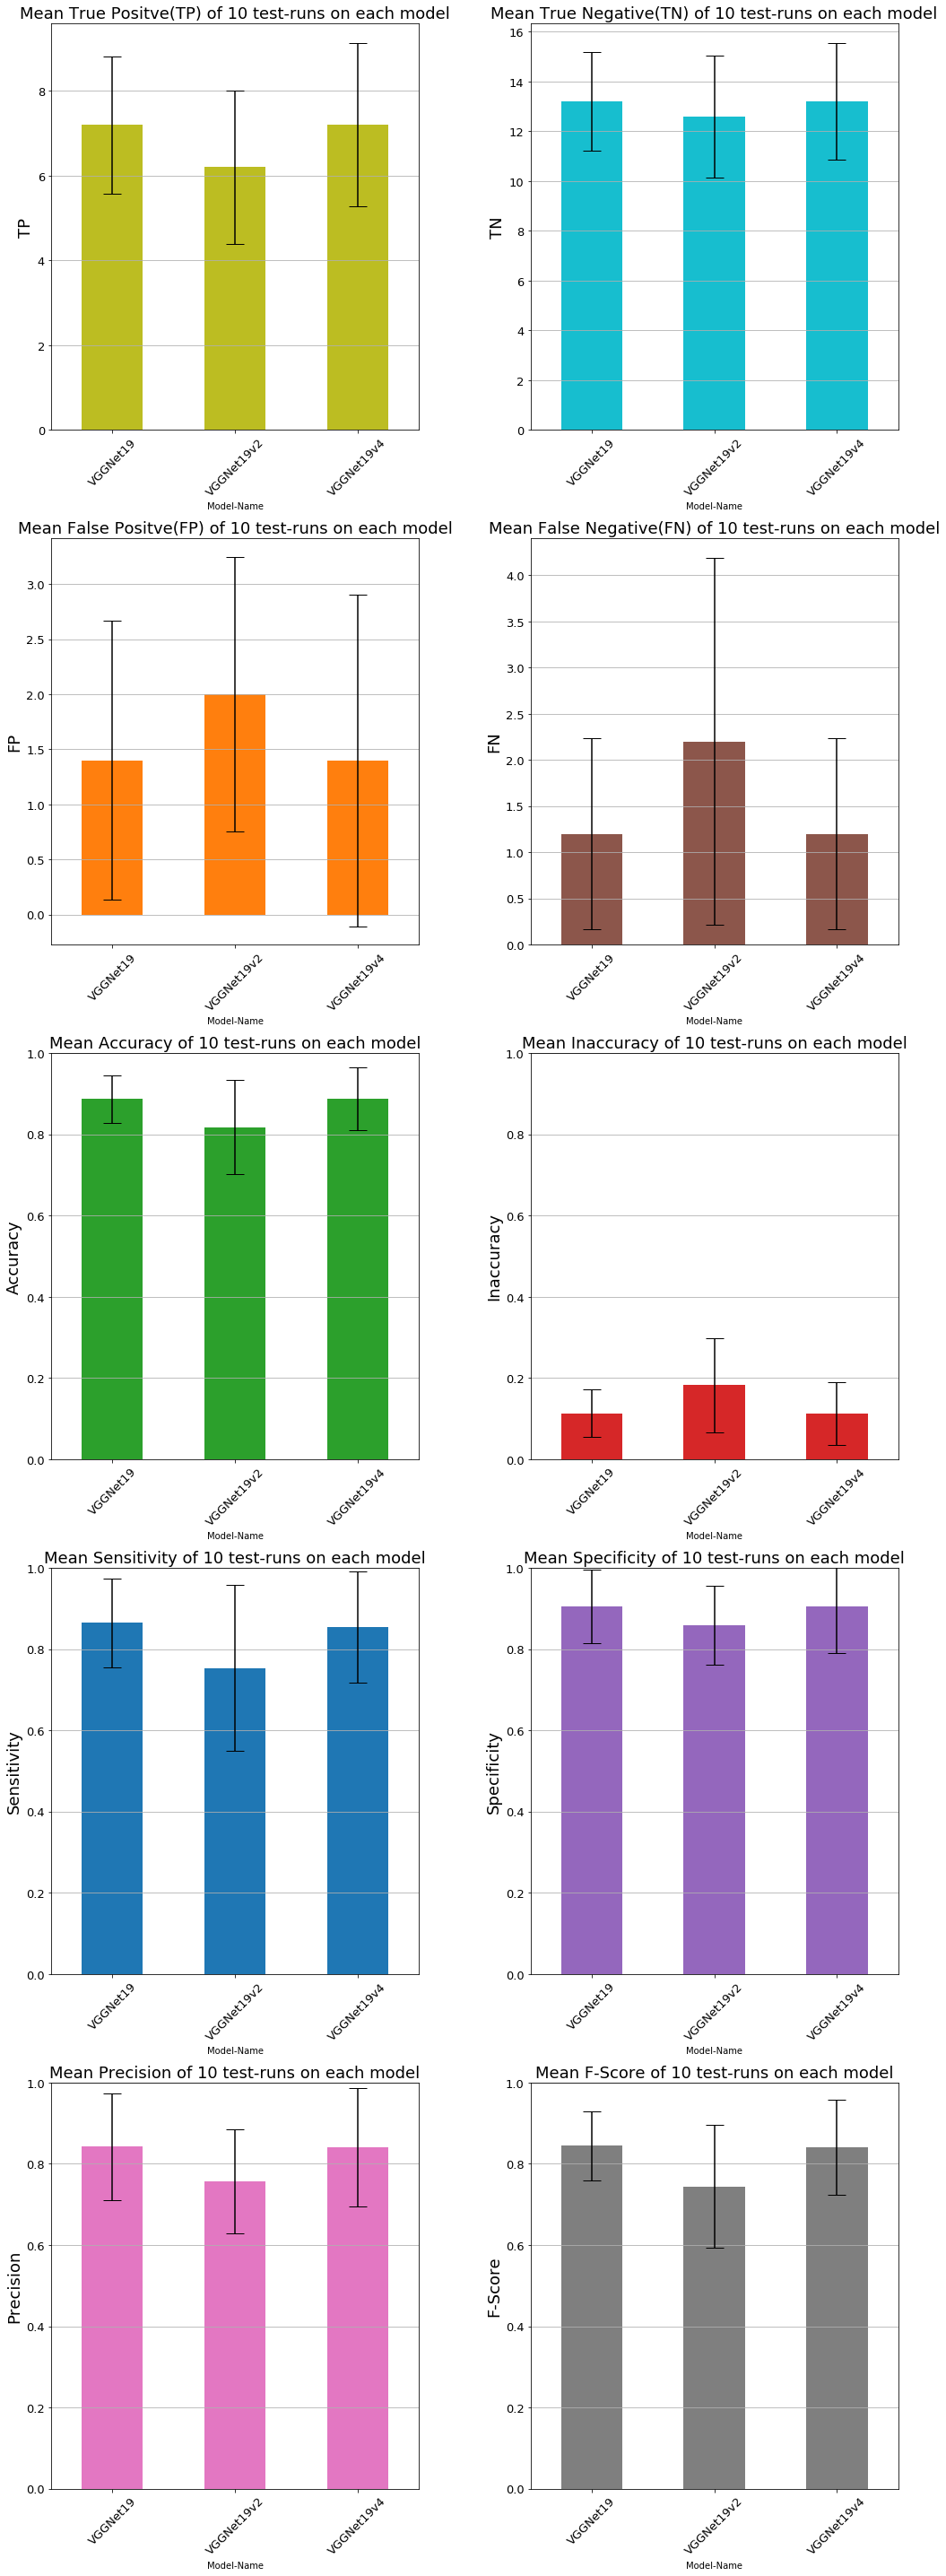

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=2)

size=(15,40)
n='10'

p00 = byModel['TP'].mean().plot(ax=axes[0,0], yerr=byModel['TP'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:olive", figsize=size)
p00.set_title("Mean True Positve(TP) of %s test-runs on each model"%n, fontsize=18)
#p00.set_xlabel("Model", fontsize=18)
p00.set_ylabel("TP", fontsize=18)
p00.yaxis.grid(True)

p01 = byModel['TN'].mean().plot(ax=axes[0,1], yerr=byModel['TN'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:cyan", figsize=size)
p01.set_title("Mean True Negative(TN) of %s test-runs on each model"%n, fontsize=18)
#p01.set_xlabel("Model", fontsize=18)
p01.set_ylabel("TN", fontsize=18)
p01.yaxis.grid(True)

p10 = byModel['FP'].mean().plot(ax=axes[1,0], yerr=byModel['FP'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:orange", figsize=size)
p10.set_title("Mean False Positve(FP) of %s test-runs on each model"%n, fontsize=18)
#p10.set_xlabel("Model", fontsize=18)
p10.set_ylabel("FP", fontsize=18)
p10.yaxis.grid(True)

p11 = byModel['FN'].mean().plot(ax=axes[1,1], yerr=byModel['FN'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:brown", figsize=size)
p11.set_title("Mean False Negative(FN) of %s test-runs on each model"%n, fontsize=18)
#p11.set_xlabel("Model", fontsize=18)
p11.set_ylabel("FN", fontsize=18)
p11.yaxis.grid(True)

p20 = byModel['Accuracy'].mean().plot(ax=axes[2,0], yerr=byModel['Accuracy'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:green", figsize=size)
p20.set_title("Mean Accuracy of %s test-runs on each model"%n, fontsize=18)
#p20.set_xlabel("Model", fontsize=18)
p20.set_ylabel("Accuracy", fontsize=18)
p20.yaxis.grid(True)
p20.set_ylim(0,1)

p21 = byModel['Inaccuracy'].mean().plot(ax=axes[2,1], yerr=byModel['Inaccuracy'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:red", figsize=size)
p21.set_title("Mean Inaccuracy of %s test-runs on each model"%n, fontsize=18)
#p21.set_xlabel("Model", fontsize=18)
p21.set_ylabel("Inaccuracy", fontsize=18)
p21.yaxis.grid(True)
p21.set_ylim(0,1)

p30 = byModel['Sensitivity'].mean().plot(ax=axes[3,0], yerr=byModel['Sensitivity'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:blue", figsize=size)
p30.set_title("Mean Sensitivity of %s test-runs on each model"%n, fontsize=18)
#p30.set_xlabel("Model", fontsize=18)
p30.set_ylabel("Sensitivity", fontsize=18)
p30.yaxis.grid(True)
p30.set_ylim(0,1)

p31 = byModel['Specificity'].mean().plot(ax=axes[3,1], yerr=byModel['Specificity'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:purple", figsize=size)
p31.set_title("Mean Specificity of %s test-runs on each model"%n, fontsize=18)
#p31.set_xlabel("Model", fontsize=18)
p31.set_ylabel("Specificity", fontsize=18)
p31.yaxis.grid(True)
p31.set_ylim(0,1)

p40 = byModel['Precision'].mean().plot(ax=axes[4,0], yerr=byModel['Precision'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:pink", figsize=size)
p40.set_title("Mean Precision of %s test-runs on each model"%n, fontsize=18)
#p40.set_xlabel("Model", fontsize=18)
p40.set_ylabel("Precision", fontsize=18)
p40.yaxis.grid(True)
p40.set_ylim(0,1)

p41 = byModel['F-Score'].mean().plot(ax=axes[4,1], yerr=byModel['F-Score'].std(), kind="bar", rot=45, fontsize=13, ecolor='black', capsize=10, color="tab:gray", figsize=size)
p41.set_title("Mean F-Score of %s test-runs on each model"%n, fontsize=18)
#p41.set_xlabel("Model", fontsize=18)
p41.set_ylabel("F-Score", fontsize=18)
p41.yaxis.grid(True)
p41.set_ylim(0,1)

plt.tight_layout()
plt.savefig(load_dir + '/test_inference_plot.png', dpi=500)
plt.show()